In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor

from torch import Tensor
from torch.optim.optimizer import Optimizer
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from pathlib import PosixPath
from typing import List, Any, Union, Dict, Optional, Tuple, Generator, Collection
from torch.utils.data import Dataset
from tqdm import tqdm,trange

import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, MultiStepLR

LRScheduler = _LRScheduler
ModelParams = Generator[Tensor,Tensor,Tensor]

plot_epoch_t = []
plot_train_loss =[]
plot_epoch_v = []
plot_val_loss = []
        
      
# This is related to wide neural network
class wide(nn.Module):
    # num_input = number of input
    # num_output = number of output
    def __init__(self,num_input,num_output):
        super(wide, self).__init__()
        self.widenn = nn.Linear(num_input,num_output)
        
    def forward(self,x):
        out = self.widenn(x)
        return out
        
        

In [0]:
def deep_layer(layer_in,layer_out,dropout):
    ly = nn.Sequential(nn.Linear(layer_in, layer_out),nn.LeakyReLU(inplace=True), nn.Dropout(dropout))
    return ly

# Deep neural network
# Code for deep neural network taken from Wide-and-Deep-PyTorch and edited for our dataset
class deep(nn.Module):
    
    # For regression output dimention is 1
    def __init__(self, embeddings_input:List[Tuple[str,int,int]],
        embeddings_encoding_dict:Dict[str,Any], continuous_cols:List[str],
        deep_column_idx:Dict[str,int], hidden_layers:List[int], dropout:List[float],
        output_dim=1):
        
        super(deep, self).__init__()

        self.embeddings_input = embeddings_input
        self.embeddings_encoding_dict = embeddings_encoding_dict
        self.continuous_cols = continuous_cols
        self.deep_column_idx = deep_column_idx

        for col,val,dim in embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))
        input_emb_dim = np.sum([emb[2] for emb in embeddings_input])+len(continuous_cols)
        hidden_layers = [input_emb_dim] + hidden_layers
        dropout = [0.0] + dropout
        self.dense = nn.Sequential()
        for i in range(1, len(hidden_layers)):
            self.dense.add_module(
                'deep_layer{}'.format(i-1),
                deep_layer( hidden_layers[i-1], hidden_layers[i], dropout[i-1])
                )
        self.dense.add_module('last_linear', nn.Linear(hidden_layers[-1], output_dim))

    def forward(self, X:Tensor)->Tensor:
        emb = [getattr(self, 'emb_layer_'+col)(X[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]
        if self.continuous_cols:
            cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
            cont = [X[:, cont_idx].float()]
            inp = torch.cat(emb+cont, 1)
        else:
            inp = torch.cat(emb, 1)
        out = self.dense(inp)
        return out

In [0]:
# Combining wide and deep neural networks

class widedeep(nn.Module):
    def __init__(self,**params):
        super(widedeep,self).__init__()
        
        self.datasets = {} # dictionary 2 -> wide dataset and deep dataset
        self.out_dim = 1 # for regression (predicts the user rate)
        self.n_datasets = 1
        
        # Get parameters for wide dataset
        for key,val in params['wide'].items():
            setattr(self, key, val) # we are getting wide_dim
            
        # instantiation of wide objects
        self.widenn = wide(
            self.wide_dim,
            self.out_dim
            )
        
        # Get parameters for deep dataset
        for key,val in params['deep'].items():
            setattr(self, key, val)
        self.datasets['deep'] = self.n_datasets
        self.n_datasets+=1
        self.deepnn = deep(
            self.embeddings_input,
            self.embeddings_encoding_dict,
            self.continuous_cols,
            self.deep_column_idx,
            self.hidden_layers,
            self.dropout,
            self.out_dim
        )
        
    def settings(self):
#         method = 'regression'
        method = 'logistic'
        self.method = method
        self.activation, self.criterion = None, F.mse_loss
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.lr_scheduler = None
        
    def forward(self, X:Tuple[Tensor,...])->Tensor:
        
        # wide network
        wide_input = X[0]
        wide_deep = self.widenn(wide_input)
        
        # Deep network
        deep_dense_idx = self.datasets['deep']
        deep_dense_out = self.deepnn(X[0])
        wide_deep.add_(deep_dense_out)
        
        # If no activation sigmoid etc. otherwise use activation funct.
        return wide_deep
    
    def trainModel(self,n_epochs,train_loader,eval_loader=None):
        train_steps =  (len(train_loader.dataset) // train_loader.batch_size) + 1
        global plot_epoch_t,plot_epoch_v,plot_train_loss,plot_val_loss
        
        plot_epoch_t = []
        plot_epoch_v = []
        plot_train_loss =[]
        plot_val_loss = []
        
        if eval_loader:
            eval_steps =  (len(eval_loader.dataset) // eval_loader.batch_size) + 1
            
        for epoch in range(n_epochs):
            if self.lr_scheduler: self.lr_scheduler.step()
            net = self.train()
            total, correct, running_loss = 0,0,0
            with trange(train_steps) as t:
                for i, (data,target) in zip(t, train_loader):
                    t.set_description('epoch %i' % (epoch+1))
                    X = tuple(x.cuda() for x in data) if use_cuda else data
                    y = target.float() if self.method != 'multiclass' else target
                    y = y.cuda() if use_cuda else y

                    self.optimizer.zero_grad()
                    y_pred =  net(X)
                    if(self.criterion == F.cross_entropy):
                        loss = self.criterion(y_pred, y)
                    else:
                        loss = self.criterion(y_pred, y.view(-1, 1))
                    loss.backward()
                    self.optimizer.step()

                    running_loss += loss.item()
                    avg_loss = running_loss/(i+1)

                    if self.method != "regression":
                        total+= y.size(0)
                        if self.method == 'logistic':
                            y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                        if self.method == "multiclass":
                            _, y_pred_cat = torch.max(y_pred, 1)
                        correct+= float((y_pred_cat == y).sum().item())
                        t.set_postfix(acc=correct/total, loss=avg_loss)
                    else:
                        t.set_postfix(loss=np.sqrt(avg_loss))
                    plot_epoch_t.append(epoch)
                    plot_train_loss.append(avg_loss)

            if eval_loader:
                total, correct, running_loss = 0,0,0
                net = self.eval()
                with torch.no_grad():
                    with trange(eval_steps) as v:
                        for i, (data,target) in zip(v, eval_loader):
                            v.set_description('valid')
                            X = tuple(x.cuda() for x in data) if use_cuda else data
                            y = target.float() if self.method != 'multiclass' else target
                            y = y.cuda() if use_cuda else y
                            y_pred =  net(X)
                            if(self.criterion == F.cross_entropy):
                                loss = self.criterion(y_pred, y)
                            else:
                                loss = self.criterion(y_pred, y.view(-1, 1))
                            running_loss += loss.item()
                            avg_loss = running_loss/(i+1)
                            if self.method != "regression":
                                total+= y.size(0)
                                if self.method == 'logistic':
                                    y_pred_cat = (y_pred > 0.5).squeeze(1).float()
                                if self.method == "multiclass":
                                    _, y_pred_cat = torch.max(y_pred, 1)
                                correct+= float((y_pred_cat == y).sum().item())
                                v.set_postfix(acc=correct/total, loss=avg_loss)
                            else:
                                v.set_postfix(loss=np.sqrt(avg_loss))
                            plot_epoch_v.append(epoch)
                            plot_val_loss.append(avg_loss)

                            

In [5]:
cd drive/

/content/drive


In [6]:
cd My\ Drive

/content/drive/My Drive


In [7]:
cd Wide-and-Deep-PyTorch/

/content/drive/My Drive/Wide-and-Deep-PyTorch


In [46]:
data = pd.read_csv('data/IMDB/imdb.csv', header=0, error_bad_lines=False)
data.columns = [c.replace("-", "_") for c in data.columns]
data["imdbRating"] = data["imdbRating"].fillna(0).astype(int)

b'Skipping line 66: expected 44 fields, saw 46\nSkipping line 111: expected 44 fields, saw 45\nSkipping line 198: expected 44 fields, saw 45\nSkipping line 222: expected 44 fields, saw 46\nSkipping line 278: expected 44 fields, saw 45\nSkipping line 396: expected 44 fields, saw 45\nSkipping line 403: expected 44 fields, saw 45\nSkipping line 421: expected 44 fields, saw 45\nSkipping line 437: expected 44 fields, saw 45\nSkipping line 462: expected 44 fields, saw 46\nSkipping line 491: expected 44 fields, saw 45\nSkipping line 515: expected 44 fields, saw 45\nSkipping line 529: expected 44 fields, saw 45\nSkipping line 530: expected 44 fields, saw 45\nSkipping line 558: expected 44 fields, saw 45\nSkipping line 623: expected 44 fields, saw 45\nSkipping line 646: expected 44 fields, saw 45\nSkipping line 663: expected 44 fields, saw 46\nSkipping line 713: expected 44 fields, saw 45\nSkipping line 730: expected 44 fields, saw 47\nSkipping line 791: expected 44 fields, saw 45\nSkipping lin

In [0]:
x = data['imdbRating']
x[x > 7] = 8
x[x <= 7] = 7
data['imdbRating'] = x

strs = ["" for x in range(14332)]
for i, v in enumerate(data['imdbRating']):
  strs[i] = str(v)

data['imdbRating'] = strs.copy()
data['imdbRating_label'] = (data['imdbRating'].apply(lambda x: "8" in x)).astype(int)

In [48]:
# WIDE
wide_cols = ['fn', 'ratingCount', 'duration', 'year', 'wordsInTitle']
crossed_cols = ()

# DEEP DENSE
embeddings_cols = [('title', 16), ('wordsInTitle', 16), ('tid', 16)]

continuous_cols = ["duration","year", "nrOfUserReviews", "nrOfGenre", "nrOfNewsArticles", "nrOfPhotos", "nrOfNominations", "nrOfWins"
                   , "ratingCount"]

standardize_cols = continuous_cols
out_dir = 'data/IMDB/wide_deep_data'

#TARGET: logistic
target = 'imdbRating_label'
data.head()

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,FilmNoir,GameShow,History,Horror,Music,Musical,Mystery,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,imdbRating_label
0,titles01/tt0012349,tt0012349,Der Vagabund und das Kind (1921),der vagabund und das kind,http://www.imdb.com/title/tt0012349/,8,40550.0,3240.0,1921.0,video.movie,1,0,19,96,85,3,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,titles01/tt0015864,tt0015864,Goldrausch (1925),goldrausch,http://www.imdb.com/title/tt0015864/,8,45319.0,5700.0,1925.0,video.movie,2,1,35,110,122,3,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,titles01/tt0017136,tt0017136,Metropolis (1927),metropolis,http://www.imdb.com/title/tt0017136/,8,81007.0,9180.0,1927.0,video.movie,3,4,67,428,376,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,titles01/tt0017925,tt0017925,Der General (1926),der general,http://www.imdb.com/title/tt0017925/,8,37521.0,6420.0,1926.0,video.movie,1,1,53,123,219,3,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,titles01/tt0021749,tt0021749,Lichter der Großstadt (1931),lichter der gro stadt,http://www.imdb.com/title/tt0021749/,8,70057.0,5220.0,1931.0,video.movie,2,0,38,187,186,3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [22]:
# # Adult dataset

# DATA_PATH=Path('data')
# # the following will all happen if you simply run: python prepare_data.py --dataset adult
# DF_adult = pd.read_csv(DATA_PATH/'adult/adult.csv')
# DF_adult.columns = [c.replace("-", "_") for c in DF_adult.columns]
# DF_adult['income_label'] = (DF_adult["income"].apply(lambda x: ">50K" in x)).astype(int)
# DF_adult.drop("income", axis=1, inplace=True)
# DF_adult['age_buckets'] = pd.cut(DF_adult.age, bins=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65],
#     labels=np.arange(9))
# out_dir = DATA_PATH/'adult/wide_deep_data/'

# # WIDE
# wide_cols = ['age_buckets', 'education', 'relationship','workclass','occupation',
#     'native_country','gender']
# # crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])
# crossed_cols = ()

# # DEEP DENSE
# embeddings_cols = [('education',16), ('relationship',16), ('workclass',16),
#     ('occupation',16),('native_country',16)]
# continuous_cols = ["age","hours_per_week"]
# standardize_cols = continuous_cols

# #TARGET: logistic
# target = 'income_label'
# DF_adult.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_label,age_buckets
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0,3
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1,4
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0,NaN


In [49]:
from prepare_data_t1 import prepare_data_adult
wd_dataset_imdb = prepare_data_adult(
    data, wide_cols,
    crossed_cols,
    embeddings_cols,
    continuous_cols,
    standardize_cols,
    target, out_dir,
    scale=True
    )

Wide and Deep adult data preparation completed.


In [24]:
# # For adult dataset

# from prepare_data_t1 import prepare_data_adult
# wd_dataset_imdb = prepare_data_adult(
#     DF_adult, wide_cols,
#     crossed_cols,
#     embeddings_cols,
#     continuous_cols,
#     standardize_cols,
#     target, out_dir,
#     scale=True
#     )

Wide and Deep adult data preparation completed.


In [0]:
wd_dataset_imdb.keys()
wd_dataset_imdb['train'].keys()
params = dict()
params['wide'] = dict(
    wide_dim = wd_dataset_imdb['train']['wide'].shape[1]
    )
params['deep'] = dict(
    embeddings_input = wd_dataset_imdb['cat_embeddings_input'],
    embeddings_encoding_dict = wd_dataset_imdb['cat_embeddings_encoding_dict'],
    continuous_cols = wd_dataset_imdb['continuous_cols'],
    deep_column_idx = wd_dataset_imdb['deep_column_idx'],
    hidden_layers = [64,32],
    dropout = [0.5]
    )

model1 = widedeep(**params)

In [51]:
model1

widedeep(
  (widenn): wide(
    (widenn): Linear(in_features=37054, out_features=1, bias=True)
  )
  (deepnn): deep(
    (emb_layer_title): Embedding(14332, 16)
    (emb_layer_wordsInTitle): Embedding(13605, 16)
    (emb_layer_tid): Embedding(14332, 16)
    (dense): Sequential(
      (deep_layer0): Sequential(
        (0): Linear(in_features=57, out_features=64, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace)
        (2): Dropout(p=0.0)
      )
      (deep_layer1): Sequential(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): LeakyReLU(negative_slope=0.01, inplace)
        (2): Dropout(p=0.5)
      )
      (last_linear): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [0]:
model1.settings()

In [0]:
use_cuda = torch.cuda.is_available()

In [0]:
if use_cuda:
    model1 = model1.cuda()

In [0]:
#print(wd_dataset_imdb['train'])

In [0]:
# Data Loader
class WideDeepLoader(Dataset):
    def __init__(self, data:Dict[str,Any], transform:Optional=None, mode:str='train'):

        self.mode = mode
        input_types = list(data.keys())
        self.input_types = input_types
        self.X_wide = data['wide']
        if 'deep' in self.input_types: self.X_deep_dense = data['deep']
        if self.mode is 'train':
            self.Y = data['target']
        elif self.mode is 'test':
            self.Y = None

    def __getitem__(self, idx:int):

        xw = self.X_wide[idx]
        X = (xw, )
        if 'deep' in self.input_types:
            xdd = self.X_deep_dense[idx]
            X += (xdd,)
        if self.mode is 'train':
            y  = self.Y[idx]
            return X, y
        elif self.mode is 'test':
            return X

    def __len__(self):
        return len(self.X_wide)


In [57]:
train_set = WideDeepLoader(wd_dataset_imdb['train'], mode='train')
valid_set = WideDeepLoader(wd_dataset_imdb['valid'], mode='train')
test_set = WideDeepLoader(wd_dataset_imdb['test'], mode='test')
train_set

In [58]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,
    batch_size=128,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,
    batch_size=128,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
    batch_size=32,shuffle=False)
model1.trainModel(n_epochs=50, train_loader=train_loader, eval_loader=valid_loader)

valid: 100%|██████████| 23/23 [00:00<00:00, 58.61it/s, acc=0.815, loss=0.155]


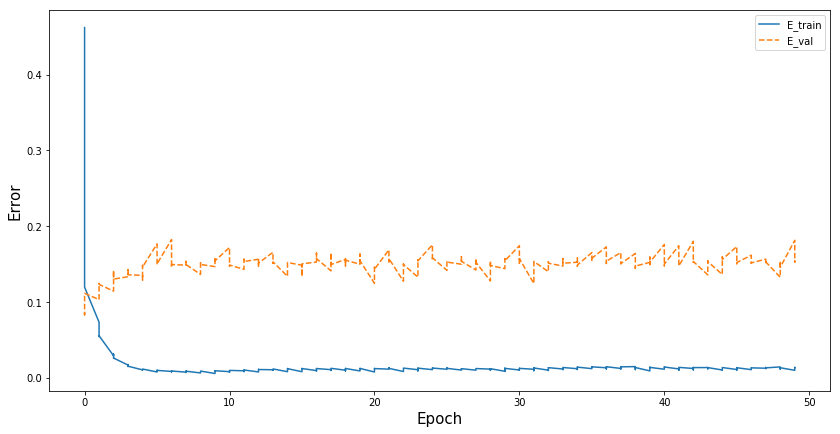

In [59]:
# Plot global plot_epoch_v,plot_epoch_t,plot_train_loss,plot_val_loss
plt.figure(figsize=(14,7))
# print(plot_epoch)
plt.plot(plot_epoch_t, plot_train_loss, '-', label='E_train')
plt.plot(plot_epoch_v, plot_val_loss, '--', label='E_val')
plt.xlabel('Epoch', size=15)
plt.ylabel('Error', size=15)
plt.legend()
plt.show()